2024/12/09

[Neurosity Python SDK](https://github.com/neurosity/neurosity-sdk-python) を利用した Python 環境で動く [Neurosity Crown](https://neurosity.co/crown) 用GUI

Jupyter notebook上で計測後解析も可．これをベースに心理実験用にカスタマイズしても良い．

# Get Started
Conda環境は未確認．Venv+pip推奨．WSLも可

ライブラリのインストール:
```sh
pip install numpy scipy neurosity pygame
```

`./env.py` にNeurosityアカウントのメールアドレス・パスワード，デバイスIDを書いておく:
```python
NEUROSITY_EMAIL = "xxxxxxxxxxx@gmail.com"
NEUROSITY_PASSWORD = "xxxxxxxxxxxxxxx"
NEUROSITY_DEVICE_ID = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
```

あとは上から順にセル実行するだけ

In [1]:
from env import NEUROSITY_EMAIL, NEUROSITY_PASSWORD, NEUROSITY_DEVICE_ID
from neurosity import NeurositySDK
neurosity = NeurositySDK({"device_id": NEUROSITY_DEVICE_ID})
neurosity.login({"email": NEUROSITY_EMAIL, "password": NEUROSITY_PASSWORD})
SFREQ = 256

In [ ]:
import numpy as np
from scipy import signal

def normalize(X, sfreq=250, fmin=3, fmax=40):   # (channels, time_length)
    X = signal.lfilter(*signal.butter(5, np.array([fmin, fmax])/(sfreq/2), btype="bandpass"), X, axis=1)
    X = signal.lfilter(*signal.butter(5, np.array([fmax,   70])/(sfreq/2), btype="bandstop"), X, axis=1)
    X = signal.lfilter(*signal.iirnotch(50, 20, sfreq), X, axis=1)
    return X

class EEGDataCollector:
    def __init__(self, sfreq=256, max_seconds=60):
        self.data = np.full((9, max_seconds*sfreq), 0)
        self.t = 10 * sfreq # フィルタ用パディング
        self.jst_offset = 9 * 86400 * 1000

    def callback(self, data: dict): # "label", "info", "data"
        info = data["info"] # "channelNames": [], "startTime": 1733565285293.398, "samplingRate": 256, ("notchFrequency": "60Hz")
        self.data[0,  self.t:self.t+16] = info["startTime"] + np.arange(16)/info["samplingRate"] + self.jst_offset
        self.data[1:, self.t:self.t+16] = data["data"]
        self.t += 16

# import time
# data_collector = EEGDataCollector()
# unsubscribe = neurosity.brainwaves_raw_unfiltered(data_collector.callback)
# time.sleep(1)
# unsubscribe()

In [ ]:
import os
import pygame as pg

# COLORS = np.array([(0,0,255), (0,255,255), (0,255,0), (255,255,0), (255,0,0), (255,0,255), (255,255,255), (127,127,127)])   # (for OpenBCI)
COLORS = np.array([(0,0,255), (0,255,0), (255,0,0), (255,255,255), (127,127,127), (255,0,255), (255,255,0), (0,255,255)])   # (for Crown)
# ELECTRODE_POS = [(-1.0,3.6), (1.0,3.6), (-1.7,0.0), (1.7,0.0), (-2.9,-2.3), (2.9,-2.3), (-1.0,-3.5), (1.0,-3.5)]   # Fp1, Fp2, C3, C4, T5, T6, O1, O2 (for OpenBCI)
ELECTRODE_POS = [(-1.6,-1.0), (-1.7,0.0), (-2.1,2.0), (-1.1,-3.0), (1.1,-3.0), (2.1,2.0), (1.7,0.0), (1.6,-1.0)]   # CP3, C3, F5, PO3, PO4, F6, C4, CP4 (for Crown)

class BCIRenderer:
    def __init__(self, trange=3, fmax=70):
        self.win: pg.Surface = None
        self.font: pg.font.Font = None
        self.trange = trange
        self.fmax = fmax

    def draw_waves(self, data: np.ndarray, left=0, top=0, right=640, bottom=480, trange=3, maxuV=100):
        W = right - left
        H = bottom - top
        h = H // 16 # 振幅の半分のピクセル数
        x = np.linspace(left, right, data.shape[1])
        Y = h + data.clip(-maxuV, maxuV) * h / maxuV
        for i, y in enumerate(Y):
            topi = top + 2 * h * i
            pg.draw.lines(self.win, COLORS[i], False, np.c_[x, y+topi])
            pg.draw.line(self.win, "white", (left, topi), (right, topi))
        pg.draw.line(self.win, "white", (left, bottom), (right, bottom))

        for t, x in enumerate(np.linspace(right, left, trange+1).astype(int)):
            pg.draw.line(self.win, "gray", (x, top), (x, bottom))
            self.win.blit(self.font.render(f" -{t}", True, "white"), (x, bottom-20))

    def draw_spec(self, data: np.ndarray, left=0, top=0, right=640, bottom=480, fmax=70, lim=100):
        freq, Vs = signal.welch(data, SFREQ, scaling="spectrum")
        lnAs = np.log(Vs[:, :fmax+1] * data.shape[1] * 1e-3 + 1e-12)
        Y = (top - bottom) * lnAs.clip(0, lim) / lim + bottom
        x = np.linspace(left, right, Y.shape[1])
        for i, y in enumerate(Y):
            pg.draw.lines(self.win, COLORS[i], False, np.c_[x, y])
        for freq in range(0, fmax+1, 10):
            x = left + (right-left) * freq / fmax
            pg.draw.line(self.win, "gray", (x, top), (x, bottom))
            self.win.blit(self.font.render(f"{freq}", True, "white"), (x, bottom-20))
        pg.draw.line(self.win, "gray", (left, top), (right, top))
        pg.draw.line(self.win, "gray", (left, bottom), (right, bottom))

    def draw_network(self, data: np.ndarray, left=0, top=0, right=100, bottom=100):
        A = np.nan_to_num(np.corrcoef(data), 0)
        power = abs(A).mean(0)
        # A = ((1 + np.corrcoef(data)) * (255 / 2)).astype(int)
        wzoom, hzoom, cx, cy = (right-left)/10, (bottom-top)/10, (right+left)/2, (bottom+top)/2
        pos = [(cx + wzoom*ELECTRODE_POS[i][0], cy - hzoom*ELECTRODE_POS[i][1]) for i in range(8)]
        for i in range(8):
            for j in range(i+1, 8):
                c = (COLORS[i] + COLORS[j]) / 2
                pg.draw.line(self.win, c, pos[i], pos[j], int(wzoom/2*A[i, j]+1))
            pg.draw.circle(self.win, COLORS[i], pos[i], int(wzoom*power[i]/2+1))
            self.win.blit(self.font.render(f"{power[i]:.2f}", True, "white"), pos[i])

    def draw(self, section_data: np.ndarray, win: pg.Surface, font: pg.font.Font, clock: pg.time.Clock, downkeys: list):
        self.win = win
        self.font = font
        winw, winh = pg.display.get_window_size()
        self.draw_waves(section_data, 0, winh//2, winw, winh, self.trange)
        self.draw_spec(section_data, 0, 0, winw*4//6, winh//2, self.fmax, lim=5)
        self.draw_network(section_data, winw*4//6, 0, winw, winh//2)
        self.win.blit(self.font.render(f"{clock.get_fps():4.0f}", True, "white"), (0, 0))

class GUI:
    def __init__(self, bci_renderer: BCIRenderer):
        self.bci_renderer = bci_renderer

    def mainloop(self, win_wh=(1280, 720)):
        pg.init()
        self.win = pg.display.set_mode(win_wh)
        self.clock = pg.time.Clock()
        self.font = pg.font.SysFont("MS Gothic" if os.name in {"nt", "posix"} else "Noto Sans Mono", 32)

        self.data_collector = EEGDataCollector(max_seconds=600)
        # self.unsubscribe = neurosity.brainwaves_raw(self.data_collector.callback)
        self.unsubscribe = neurosity.brainwaves_raw_unfiltered(self.data_collector.callback)

        self.done = False
        while not self.done:
            self.win.fill((0, 0, 0))
            self.downkeys = []
            for event in pg.event.get():
                if event.type == pg.QUIT:
                    self.done = True
                elif event.type == pg.KEYDOWN:
                    self.downkeys.append(event.key)
                    if event.key == pg.K_ESCAPE:
                        self.done = True
            section_data = self.data_collector.data[1:, self.data_collector.t-(self.bci_renderer.trange+1)*SFREQ:self.data_collector.t]
            section_data = normalize(section_data, SFREQ)
            self.bci_renderer.draw(section_data[:, SFREQ:], self.win, self.font, self.clock, self.downkeys)
            self.clock.tick()
            pg.display.update()
        print("unsubscribing...")
        self.unsubscribe()
        pg.quit()

bci = BCIRenderer(trange=3)
gui = GUI(bci)
gui.mainloop()

unsubscribing...


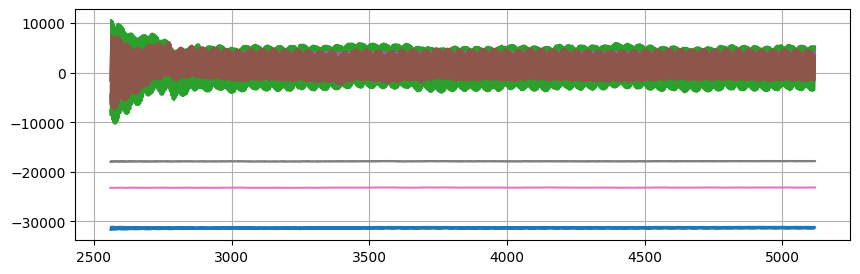

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(gui.data_collector.data[1:, :20*SFREQ].T)
# plt.plot(gui.data_collector.data[1:, gui.data_collector.t-32:gui.data_collector.t+16].T)
plt.grid()